# Introduction

My goal will be be to use the twitter API to import tweets related to a user or a hashtag. I will use NLP Bag of Words to create features on this data. I will organize this data as a network, visualize that network, and analyze that network in order to discover the most central tweets and the tweets with the greatest centrality in the network of ideas. Lastly I will perform Sentiment Analysis of the Tweets. 

Within this I will perform Sentiment Analysis using words from a lexicon from this paper:

Minqing Hu and Bing Liu. "Mining and Summarizing Customer Reviews." Proceedings of the ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD-2004), Aug 22-25, 2004, Seattle, Washington, USA,

Because the politics is so top of mind for people nowadays I will do Twitter analysis against politicians: Donald Trump, Joe Biden, and Tulsi Gabbard. 

## Importing Libraries and Data

In [1]:
# Import tweepy and json libraries
import tweepy
from tweepy import OAuthHandler
import json

In [2]:
# Setting twitter credentials, to be removed before sharing
consumer_key = 'V8z7bzGEJXUhIf1yiJoPCxRog'
consumer_secret = 'b0mr1wUZXmPnvUFnncYyozqq7m25vVdf9qZzalr2auviQf7RLC'
access_token = '180036582-qo66jqNGdUDHITZ56JpaOSANbQbEzWbZ45YRrF0M'
access_secret = 'xPD4j1sqHhmAaHJacmJ5v4slN3lUu3tPYYXTeNfub02U8'
 
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
 
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [33]:
# Basic analytical, visualization, and dataprocessing libraries
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')

import time
import math
import string
from collections import defaultdict

In [4]:
# Import language related libraries
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
import re
from collections import Counter
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer
from nltk import bigrams

In [5]:
# Import graph related libraries
import networkx as nx
from itertools import combinations
from nxviz import CircosPlot
from nxviz import ArcPlot

## Exploratory Analysis

I'll use tweepy to import data and do some initial analysis. I'll start with downloading some of my own timeline, about 20 tweets. 

In [6]:
# Download tweets
username = 'realDonaldTrump'
num_tweets = 400
exp_tweets = tweepy.Cursor(api.user_timeline, screen_name=username, tweet_mode='extended').items(num_tweets)

In [7]:
full_text_list = [tweet.full_text for tweet in exp_tweets]
print(len(full_text_list))

400


In [8]:
# Preprocessor, but replaced with TweetTokenizer
emoticons_str = r'''
    (?:
        [:=;] # Eyes
        [oO0\-]? # Nose
        [D\)\]\(\]/\\0OpP] #Mouth
    )'''

regex_str = [
    emoticons_str,
    r'<[^>]+.', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', #URLs
    r'(?:(?:\d+, ?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)', # anything else
]

tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)

def tokenize(s):
    return tokens_re.findall(s)

def preprocess(s, lowercase=False):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens

In [9]:
# Text Preprocessing
tt = TweetTokenizer()

# Tokenize
exp_tokens = [tt.tokenize(tweet) for tweet in full_text_list]

# Lowercase
exp_lower = [[token.lower() for token in tweet] for tweet in exp_tokens]

# Remove stop words
punctuation = list(string.punctuation)
stop = stopwords.words('english') + punctuation + ['rt', 'via', "…", "’", '“', '”', "i'm"]
exp_no_stops = [[token for token in tweet if token not in stop] for tweet in exp_lower]

# Lemmatization
lemmatizer = WordNetLemmatizer()
exp_lemma = [[lemmatizer.lemmatize(token) for token in tweet] for tweet in exp_no_stops]

# Hashtags list
exp_hashtags = [[token for token in tweet if token.startswith('#')] for tweet in exp_lemma]

# Mentions list
exp_mentions = [[token for token in tweet if token.startswith('@')] for tweet in exp_lemma]

# Bigrams list
exp_no_at = [[token for token in tweet if not(token.startswith(('@', '#')))] for tweet in exp_lemma]
exp_bigrams = [list(bigrams(tweet)) for tweet in exp_no_at]

In [89]:
# Generate features from common hashtags, mentions, and bigrams
limit = 5 # minimum count to be considered common

exp_count_hashtags = Counter()
exp_hashtags_flat = [item for sublist in exp_hashtags for item in sublist]
exp_count_hashtags.update(exp_hashtags_flat)
common_exp_hashtags = [((el,), value) for el, value in exp_count_hashtags.items() if value >=limit]

exp_count_mentions = Counter()
exp_mentions_flat = [item for sublist in exp_mentions for item in sublist]
exp_count_mentions.update(exp_mentions_flat)
common_exp_mentions = [((el,), value) for el, value in exp_count_mentions.items() if value >=limit]

exp_count_bigrams = Counter()
exp_bigrams_flat = [item for sublist in exp_bigrams for item in sublist]
exp_count_bigrams.update(exp_bigrams_flat)
common_exp_bigrams = [(el, value) for el, value in exp_count_bigrams.items() if value >=limit]

exp_features = common_exp_hashtags + common_exp_mentions + common_exp_bigrams
exp_features.sort(key=lambda x: x[1], reverse=True)
print(exp_features)

[(('@realdonaldtrump',), 26), (('president', 'trump'), 15), (('united', 'state'), 14), (('@foxnews',), 13), (('nothing', 'democrat'), 13), (('@seanhannity',), 12), (('witch', 'hunt'), 12), (('adam', 'schiff'), 11), (('@whitehouse',), 10), (('@ivankatrump',), 10), (('fake', 'news'), 9), (('ukrainian', 'president'), 8), (('@danscavino',), 7), (('joe', 'biden'), 7), (('@mariabartiromo',), 6), (('@paulsperry_',), 6), (('history', 'country'), 6), (('john', 'bel'), 6), (('bel', 'edward'), 6), (('crooked', 'hillary'), 6), (('quid', 'pro'), 6), (('pro', 'quo'), 6), (('radical', 'left'), 6), (('american', 'people'), 6), (('#kag2020',), 5), (('@foxandfriends',), 5), (('@repmarkmeadows',), 5), (('@kimstrassel',), 5), (('@lindseygrahamsc',), 5), (('@greggjarrett',), 5), (('get', 'vote'), 5), (('republican', 'governor'), 5), (('minneapolis', 'minnesota'), 5), (('president', 'ukraine'), 5), (('nothing', 'wrong'), 5), (('sleepy', 'joe'), 5), (('republican', 'party'), 5), (('mitt', 'romney'), 5)]


In [90]:
# Generate Graph
exp_G = nx.Graph()

# Generate Nodes
for feature, count in exp_features:
    exp_G.add_node(feature, count=count)

# Generate Edges based on Tweets
for node1, node2 in combinations(exp_G.nodes, 2): 
    for tweet in exp_lemma:
        if set(node1).issubset(set(tweet)) and set(node2).issubset(set(tweet)):
            exp_G.add_edge(node1, node2)

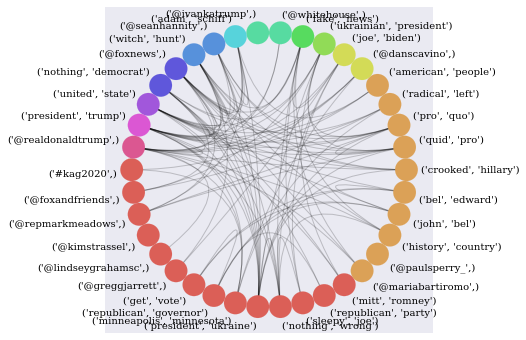

In [91]:
exp_C = CircosPlot(graph=exp_G, node_order='count', node_color='count', node_labels=True)
exp_C.draw()
plt.show()

In [92]:
# High Level Graph Metrics and Analysis

print('Occurrence:', exp_features[:10])
print()
exp_degree_dict = nx.degree_centrality(exp_G)
exp_degree_sorted = sorted(exp_degree_dict.items(), key=lambda x: x[1], reverse=True)
print('Degree Centrality:', exp_degree_sorted[:5])
print()
exp_betweenness_dict = nx.betweenness_centrality(exp_G)
exp_betweenness_sorted = sorted(exp_betweenness_dict.items(), key=lambda x: x[1], reverse=True)
print('Betweenness Centrality:', exp_betweenness_sorted[:5])
print()
exp_pagerank_dict = nx.pagerank(exp_G)
exp_pagerank_sorted = sorted(exp_pagerank_dict.items(), key=lambda x: x[1], reverse=True)
print('PageRank:', exp_pagerank_sorted[:5])
print()
exp_cliques_sorted = sorted(list(nx.find_cliques(exp_G)), key=lambda x: len(x), reverse=True)
print('Largest Maximal Clique:', exp_cliques_sorted[0])
print()
exp_connected_subgraphs = list(nx.connected_component_subgraphs(exp_G))
exp_G_lccsg = max(exp_connected_subgraphs, key=lambda x: len(x))
print('Largest Connected Component Subgraph:', exp_G_lccsg.nodes)

Occurrence: [(('@realdonaldtrump',), 26), (('president', 'trump'), 15), (('united', 'state'), 14), (('@foxnews',), 13), (('nothing', 'democrat'), 13), (('@seanhannity',), 12), (('witch', 'hunt'), 12), (('adam', 'schiff'), 11), (('@whitehouse',), 10), (('@ivankatrump',), 10)]

Degree Centrality: [(('president', 'trump'), 0.40540540540540543), (('@realdonaldtrump',), 0.35135135135135137), (('united', 'state'), 0.32432432432432434), (('@foxnews',), 0.32432432432432434), (('president', 'ukraine'), 0.32432432432432434)]

Betweenness Centrality: [(('@realdonaldtrump',), 0.1821835155168488), (('united', 'state'), 0.17838762422095755), (('president', 'trump'), 0.17531497948164612), (('nothing', 'democrat'), 0.08986916070249405), (('witch', 'hunt'), 0.06742086325419659)]

PageRank: [(('president', 'trump'), 0.06479722982777351), (('@realdonaldtrump',), 0.06169025603100898), (('united', 'state'), 0.052267531027786585), (('@foxnews',), 0.049226748063565307), (('president', 'ukraine'), 0.048829800

Largest Connected Component Subgraph


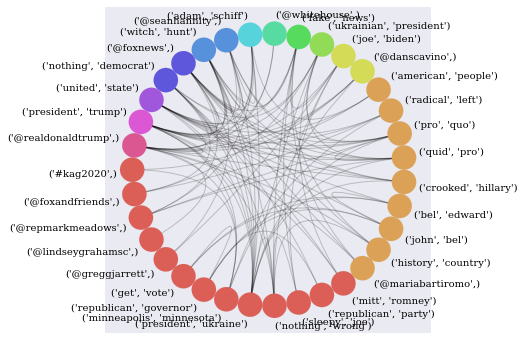

In [93]:
print('Largest Connected Component Subgraph')
exp_C_lccsg = CircosPlot(graph=exp_G_lccsg, node_order='count', node_color='count', node_labels=True)
exp_C_lccsg.draw()
plt.show()

In [94]:
# Term Neighbors
print(list(exp_G.neighbors(('joe', 'biden'))))

[('@realdonaldtrump',), ('fake', 'news'), ('@greggjarrett',), ('nothing', 'wrong'), ('sleepy', 'joe')]


In [98]:
# For sentiment analysis, creating positive and negative words from Hu-Liu lexicon, citation above
def load_words(file_name): 
    print('Loading word list from file...')
    inFile = open(file_name, 'r') 
    wordlist = []
    for line in inFile:
        wordlist.append(line.strip().lower())
    print(len(wordlist), 'words loaded.') 
    return wordlist

positive_words = load_words('positive-words-raw.txt')
negative_words = load_words('negative-words-raw.txt')

Loading word list from file...
2006 words loaded.
Loading word list from file...
4783 words loaded.


In [99]:
positive_words.remove('trump')
len(positive_words)

2005

In [152]:
exp_pos_counts = defaultdict(lambda: defaultdict(int))
for positive_word in positive_words:
    for tweet in exp_lemma:
        if set([positive_word]).issubset(set(tweet)):
            exp_pos_counts[(positive_word,)]['count'] += 1
exp_pos_counts_df = pd.DataFrame(exp_pos_counts)
exp_pos_counts_df = exp_pos_counts_df.transpose()
exp_pos_counts_df.sort_values('count', inplace=True, ascending=False)
exp_pos_counts_df.head()

,count
great,56
thank,24
good,14
win,12
love,10


In [153]:
exp_neg_counts = defaultdict(lambda: defaultdict(int))
for negative_word in negative_words:
    for tweet in exp_lemma:
        if set([negative_word]).issubset(set(tweet)):
            exp_neg_counts[(negative_word,)]['count'] += 1
exp_neg_counts_df = pd.DataFrame(exp_neg_counts)
exp_neg_counts_df = exp_neg_counts_df.transpose()
exp_neg_counts_df.sort_values('count', inplace=True, ascending=False)
exp_neg_counts_df.head()

,count
scam,13
wrong,10
fake,10
crime,10
bad,9


In [154]:
exp_feature_counts = defaultdict(lambda: defaultdict(int))
for feature, count in exp_features:
    for tweet in exp_lemma:
        if set(feature).issubset(set(tweet)):
            exp_feature_counts[feature]['count'] += 1
exp_feature_counts_df = pd.DataFrame(exp_feature_counts)
exp_feature_counts_df = exp_feature_counts_df.transpose()
exp_feature_counts_df.sort_values('count')
exp_feature_counts_df.head()

,,count
@realdonaldtrump,NaN,26
president,trump,18
united,state,14
@foxnews,NaN,12
nothing,democrat,14


In [161]:
sentiment_df = pd.DataFrame({}, columns=['feature', 'sentiment_word', 'sentiment_type', 'feature_count', 'sentiment_count', 'co-occurrences_count', 'PMI'])
exp_co_term_counts = defaultdict(lambda: defaultdict(int))
pmi_dict = defaultdict(lambda: defaultdict(int))

for feature, feature_count in exp_feature_counts.items():
    for positive_word, sentiment_count in exp_pos_counts.items():
        for tweet in exp_lemma:
            if set(feature).issubset(tweet) and set(positive_word).issubset(tweet):
                exp_co_term_counts[feature][positive_word]+=1
        if exp_co_term_counts[feature][positive_word] == 0:
            pmi_dict[feature][positive_word] = 0
        else:
            num_tweets = len(exp_lemma)
            pmi_numerator = exp_co_term_counts[feature][positive_word]/num_tweets
            pmi_denomonator = (feature_count['count']/num_tweets)*(sentiment_count['count']/num_tweets)
            pmi_dict[feature][positive_word] = math.log2(pmi_numerator/pmi_denomonator)
        sentiment_df = sentiment_df.append({
            'feature': feature, 
            'sentiment_word': positive_word, 
            'sentiment_type': 'positive',
            'feature_count': feature_count['count'], 
            'sentiment_count': sentiment_count['count'],
            'co-occurrences_count': exp_co_term_counts[feature][positive_word],
            'PMI': pmi_dict[feature][positive_word]
        }, ignore_index=True)

for feature, feature_count in exp_feature_counts.items():
    for negative_word, sentiment_count in exp_neg_counts.items():
        for tweet in exp_lemma:
            if set(feature).issubset(tweet) and set(negative_word).issubset(tweet):
                exp_co_term_counts[feature][negative_word]+=1
        if exp_co_term_counts[feature][negative_word] == 0:
            pmi_dict[feature][negative_word] = 0
        else:
            num_tweets = len(exp_lemma)
            pmi_numerator = exp_co_term_counts[feature][negative_word]/num_tweets
            pmi_denomonator = (feature_count['count']/num_tweets)*(sentiment_count['count']/num_tweets)
            pmi_dict[feature][negative_word] = math.log2(pmi_numerator/pmi_denomonator)
        sentiment_df = sentiment_df.append({
            'feature': feature, 
            'sentiment_word': negative_word, 
            'sentiment_type': 'negative',
            'feature_count': feature_count['count'], 
            'sentiment_count': sentiment_count['count'],
            'co-occurrences_count': exp_co_term_counts[feature][negative_word],
            'PMI': pmi_dict[feature][negative_word]
        }, ignore_index=True)

sentiment_df.sort_values('PMI', ascending=False).head(40)

,feature,sentiment_word,sentiment_type,feature_count,sentiment_count,co-occurrences_count,PMI
11727,"(mitt, romney)","(pompous,)",negative,5,2,2,6.32193
4283,"(republican, party)","(fabulous,)",positive,5,1,1,6.32193
11133,"(nothing, wrong)","(meltdown,)",negative,5,1,1,6.32193
4025,"(nothing, wrong)","(bright,)",positive,5,1,1,6.32193
11284,"(sleepy, joe)","(hang,)",negative,5,1,1,6.32193
11356,"(sleepy, joe)","(ripped,)",negative,5,1,1,6.32193
11702,"(mitt, romney)","(losing,)",negative,5,1,1,6.32193
11248,"(sleepy, joe)","(detriment,)",negative,5,1,1,6.32193
9766,"(@kimstrassel,)","(insanity,)",negative,5,1,1,6.32193
11706,"(mitt, romney)","(lousy,)",negative,5,1,1,6.32193


In [171]:
semantic_orientation = defaultdict(int)
for _, row in sentiment_df.iterrows():
    if row.sentiment_type=='positive':
        semantic_orientation[row.feature] = semantic_orientation[row.feature] + row.PMI
    elif row.sentiment_type=='negative':
        semantic_orientation[row.feature] = semantic_orientation[row.feature] - row.PMI
    else:
        print('error, missing semantic_orientation')

In [173]:
semantic_sorted = sorted(semantic_orientation.items(), key=lambda x:x[1], reverse=True)
top_pos = semantic_sorted[:10]
top_neg = semantic_sorted[-10:]
print('Top Pos:', top_pos)
print('Top Neg:', top_neg)

Top Pos: [(('republican', 'governor'), 34.758532095419035), (('@ivankatrump',), 26.024677973715658), (('get', 'vote'), 25.7521058262596), (('republican', 'party'), 24.883899317932862), (('minneapolis', 'minnesota'), 13.106291739269306), (('fake', 'news'), 5.548766421254989), (('@greggjarrett',), 4.7369655941662066), (('#kag2020',), 4.403541860441016), (('@danscavino',), 3.251538766995964), (('@lindseygrahamsc',), 2.999999999999999)]
Top Neg: [(('@mariabartiromo',), -28.446471538712892), (('joe', 'biden'), -30.863137138648344), (('sleepy', 'joe'), -31.609640474436812), (('president', 'ukraine'), -34.885007483150986), (('nothing', 'democrat'), -43.36596593837737), (('@seanhannity',), -47.110889593731045), (('ukrainian', 'president'), -48.375552100221434), (('@foxnews',), -53.947720658007135), (('president', 'trump'), -57.65364060468163), (('adam', 'schiff'), -73.21751112955931)]


In [175]:
sentiment_df.loc[sentiment_df['feature'] == ('@foxnews',)].sort_values('PMI', ascending=False)

,feature,sentiment_word,sentiment_type,feature_count,sentiment_count,co-occurrences_count,PMI
5153,"(@foxnews,)","(impossible,)",negative,12,1,1,5.05889
5227,"(@foxnews,)","(suck,)",negative,12,1,1,5.05889
5078,"(@foxnews,)","(concern,)",negative,12,1,1,5.05889
5098,"(@foxnews,)","(denied,)",negative,12,1,1,5.05889
5144,"(@foxnews,)","(horrible,)",negative,12,1,1,5.05889
5114,"(@foxnews,)","(doubt,)",negative,12,1,1,5.05889
5192,"(@foxnews,)","(outrage,)",negative,12,1,1,5.05889
5083,"(@foxnews,)","(controversy,)",negative,12,1,1,5.05889
454,"(@foxnews,)","(supreme,)",positive,12,2,1,4.05889
372,"(@foxnews,)","(congenial,)",positive,12,3,1,3.47393


## Define Functions: Download and Clean Data, Feature Engineering

In [176]:
def download_tweets(search_term, num_tweets=100):
    if search_term.startswith('#'):
        print(f'Hashtag: {search_term}')
        tweets = tweepy.Cursor(api.search, query=search_term, tweet_mode='extended').items(num_tweets)
    elif search_term.startswith('@'):
        print(f'User: {search_term}')
        tweets = tweepy.Cursor(api.user_timeline, screen_name=search_term, tweet_mode='extended').items(num_tweets)   
    else:
        print('Please enter a hashtag starting with "#", or a username starting with "@"')
    time.sleep(15)
    tweets_list=list(tweets)
    print(f"Expected {num_tweets} tweets, got {len(tweets_list)} tweets.")
    return tweets_list

In [177]:
def clean_tweets(tweets_list):
    full_text_tweets = [tweet.full_text for tweet in tweets_list]
    tokenized = [tt.tokenize(tweet) for tweet in full_text_tweets]
    lower = [[token.lower() for token in tweet] for tweet in tokenized]
    punctuation = list(string.punctuation)
    stop = stopwords.words('english') + punctuation + ['rt', 'via', "…", "’", '“', '”', "i'm"]
    no_stops = [[token for token in tweet if token not in stop] for tweet in lower]
    lemmatizer = WordNetLemmatizer()
    lemmatized = [[lemmatizer.lemmatize(token) for token in tweet] for tweet in no_stops]
    return lemmatized

In [309]:
def terms_w_counts_from_tweets(cleaned_tweets, limit=5):
    hashtags_list = [[(token,) for token in tweet if token.startswith('#')] for tweet in cleaned_tweets]
    mentions_list = [[(token,) for token in tweet if token.startswith('@')] for tweet in cleaned_tweets]
    no_at = [[token for token in tweet if not(token.startswith(('@', '#')))] for tweet in cleaned_tweets]
    bigrams_list = [list(bigrams(tweet)) for tweet in no_at]
    combined_list = hashtags_list + mentions_list + bigrams_list
    flattened_list = [item for sublist in combined_list for item in sublist]
    counter = Counter()
    counter.update(flattened_list)
    terms_w_counts = [(feature, value) for feature, value in counter.items() if value >=limit]
    return terms_w_counts

## Define Functions: Graph and Analyze Data

In [205]:
def gen_graph(cleaned_tweets, terms_w_counts):
    G = nx.Graph()
    for term, count in terms_w_counts:
        G.add_node(term, count=count)
    for node1, node2 in combinations(G.nodes, 2):
        for tweet in cleaned_tweets:
            if set(node1).issubset(set(tweet)) and set(node2).issubset(set(tweet)):
                if not(G.has_edge(node1, node2)):
                    G.add_edge(node1, node2)
                    G.edges[node1, node2]['weight']=1
                else:
                    G.edges[node1, node2]['weight']+=1
    return G

In [330]:
def draw_graph(G, nodes_count=20):
    nodes_sorted = sorted(list(G.nodes(data=True)), key=lambda x:x[1]['count'], reverse=True)
    top_nodes = nodes_sorted[:nodes_count]
    top_nodes = [node for node, data in top_nodes]
    sub_G = G.subgraph(top_nodes)
    c = CircosPlot(graph=sub_G, node_order='count', node_color='count', node_labels=True)
    c.draw()
    plt.show()

In [310]:
def analyze_graph(G):
    nodes_sorted = sorted(list(G.nodes(data=True)), key=lambda x:x[1]['count'], reverse=True)
    print('High Counts (10):', nodes_sorted[:10])
    print()
    degree_dict = nx.degree_centrality(G)
    degree_sorted = sorted(degree_dict.items(), key=lambda x:x[1], reverse=True)
    print('Degree Centrality (5):', degree_sorted[:5])
    print()
    betweenness_dict = nx.betweenness_centrality(G)
    betweenness_sorted = sorted(betweenness_dict.items(), key=lambda x:x[1], reverse=True)
    print('Betweenness Centrality (5):', betweenness_sorted[:5])
    print()
    pagerank_dict = nx.pagerank(G)
    pagerank_sorted = sorted(pagerank_dict.items(), key=lambda x:x[1], reverse=True)
    print('PageRank (5):', pagerank_sorted[:5])
    print()
    cliques_sorted = sorted(list(nx.find_cliques(G)), key=lambda x:len(x), reverse=True)
    print('Largest Maximal Clique:', cliques_sorted[0])
    print()
    #connected_subgraphs = list(nx.connected_component_subgraphs(G))
    #G_lccsg = max(connected_subgraphs, key=lambda x:len(x))
    #print('Largest Connected Component Subgraph:')
    #c_lccsg = CircosPlot(graph=G_lccsg, node_labels=True)
    #c_lccsg.draw()
    #plt.show()

In [278]:
def analyze_term_on_graph(term, G, weight_limit=5):
    neighbors = list(G.neighbors(term))
    sub_dict = {}
    for neighbor in neighbors:
        if G.edges[term, neighbor]['weight'] >= weight_limit:
            sub_dict[neighbor] = G.edges[term, neighbor]['weight']
    sub_dict = sorted(sub_dict.items(), key=lambda x:x[1], reverse=True)
    return sub_dict

In [307]:
def tweet_sentiments(cleaned_tweets, terms_w_counts):
    pos_counts = defaultdict(lambda: defaultdict(int))
    for positive_word in positive_words:
        for tweet in cleaned_tweets:
            if set([positive_word]).issubset(set(tweet)):
                pos_counts[(positive_word,)]['count'] += 1
    neg_counts = defaultdict(lambda: defaultdict(int))
    for negative_word in negative_words:
        for tweet in cleaned_tweets:
            if set([negative_word]).issubset(set(tweet)):
                neg_counts[(negative_word,)]['count'] += 1
    term_counts = defaultdict(lambda: defaultdict(int))
    for term, count in terms_w_counts:
        for tweet in cleaned_tweets:
            if set(term).issubset(set(tweet)):
                term_counts[term]['count'] += 1
    
    co_term_counts = defaultdict(lambda: defaultdict(int))
    pmi_dict = defaultdict(lambda: defaultdict(int))
    for term, term_count in term_counts.items():
        for positive_word, sentiment_count in pos_counts.items():
            for tweet in cleaned_tweets:
                if set(term).issubset(tweet) and set(positive_word).issubset(tweet):
                    co_term_counts[term][positive_word]+=1
            if co_term_counts[term][positive_word] == 0:
                pmi_dict[term][positive_word] = 0
            else:
                num_tweets = len(cleaned_tweets)
                pmi_numerator = co_term_counts[term][positive_word]/num_tweets
                pmi_denomonator = (term_count['count']/num_tweets)*(sentiment_count['count']/num_tweets)
                pmi_dict[term][positive_word] = math.log2(pmi_numerator/pmi_denomonator)

    for term, term_count in term_counts.items():
        for negative_word, sentiment_count in neg_counts.items():
            for tweet in cleaned_tweets:
                if set(term).issubset(tweet) and set(negative_word).issubset(tweet):
                    co_term_counts[term][negative_word]+=1
            if co_term_counts[term][negative_word] == 0:
                pmi_dict[term][negative_word] = 0
            else:
                num_tweets = len(cleaned_tweets)
                pmi_numerator = co_term_counts[term][negative_word]/num_tweets
                pmi_denomonator = (term_count['count']/num_tweets)*(sentiment_count['count']/num_tweets)
                pmi_dict[term][negative_word] = -(math.log2(pmi_numerator/pmi_denomonator))

    semantic_orientation = defaultdict(int)
    for term, scores_dict in pmi_dict.items():
        for sentimemt_word, pmi_score in scores_dict.items():
            semantic_orientation[term] = semantic_orientation[term] + pmi_score

    so_sorted = sorted(semantic_orientation.items(), key=lambda x:x[1], reverse=True)
    top_pos = so_sorted[:10]
    top_neg = so_sorted[-10:]
    top_neg.reverse()
    print('Top Pos:', top_pos)
    print()
    print('Top Neg:', top_neg)
    return semantic_sorted

In [182]:
search_term = '@JoeBiden'
num_tweets = 1000
tweets_list = download_tweets(search_term, num_tweets)

User: @JoeBiden
Expected 1000 tweets, got 1000 tweets.


In [196]:
cleaned_tweets = clean_tweets(tweets_list)
terms_w_counts = terms_w_counts_from_tweets(cleaned_tweets, limit=10)

In [323]:
G = gen_graph(cleaned_tweets, terms_w_counts)

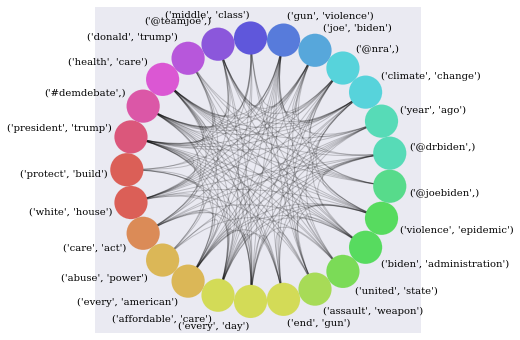

In [334]:
draw_graph(G, nodes_count=25)

In [325]:
analyze_graph(G)

High Counts (10): [(('president', 'trump'), {'count': 99}), (('#demdebate',), {'count': 89}), (('health', 'care'), {'count': 74}), (('donald', 'trump'), {'count': 68}), (('@teamjoe',), {'count': 55}), (('middle', 'class'), {'count': 46}), (('gun', 'violence'), {'count': 41}), (('joe', 'biden'), {'count': 38}), (('@nra',), {'count': 36}), (('climate', 'change'), {'count': 36})]

Degree Centrality (5): [(('president', 'trump'), 0.7613636363636364), (('#demdebate',), 0.5909090909090909), (('health', 'care'), 0.5568181818181819), (('every', 'american'), 0.5113636363636364), (('affordable', 'care'), 0.4431818181818182)]

Betweenness Centrality (5): [(('president', 'trump'), 0.10614141367229035), (('#demdebate',), 0.06261234364355427), (('health', 'care'), 0.037620459964230975), (('every', 'american'), 0.029277670322847907), (('joe', 'biden'), 0.027605613310795786)]

PageRank (5): [(('president', 'trump'), 0.038748825527360774), (('health', 'care'), 0.037630290409851615), (('affordable', 'ca

In [345]:
analyze_term_on_graph(('middle','class'), tweet_storage['@JoeBiden']['G'], weight_limit=4)

[(('come', 'along'), 9),
 (('trump', 'tax'), 8),
 (('tax', 'cut'), 8),
 (('cut', 'super-wealthy'), 8),
 (('president', 'trump'), 7),
 (('health', 'care'), 5),
 (('make', 'sure'), 4),
 (('every', 'american'), 4),
 (('work', 'wealth'), 4)]

In [308]:
semantic_orientation_sorted = tweet_sentiments(cleaned_tweets, terms_w_counts)

Top Pos: [(('@drbiden',), 77.64617566377127), (('dignity', 'respect'), 70.68419974776256), (('protect', 'build'), 50.837640156492704), (('thank', 'everyone'), 43.07682534755674), (('work', 'wealth'), 41.17593610751261), (('build', 'obamacare'), 39.13104537036775), (('join', 'u'), 33.70875693380142), (('white', 'house'), 32.88574814616075), (('100', 'million'), 32.51137926300564), (('vice', 'president'), 32.328526583409115)]

Top Neg: [(('president', 'trump'), -168.44324577017696), (('must', 'take'), -72.43799432551602), (('gun', 'violence'), -62.74051091089048), (('abuse', 'power'), -58.050075630493055), (('trump', 'administration'), -57.288991919486016), (('take', 'action'), -55.25949630059113), (('year', 'ago'), -54.69282800393759), (('donald', 'trump'), -51.76760397519774), (('violence', 'epidemic'), -48.54611594457941), (('national', 'security'), -44.9557591087318)]


In [348]:
def graph_and_summarize_tweets(search_term, num_tweets=100, nodes_count=25, term_limit=5):
    tweets_list = download_tweets(search_term, num_tweets)
    cleaned_tweets = clean_tweets(tweets_list)
    terms_w_counts = terms_w_counts_from_tweets(cleaned_tweets, limit=3)
    G = gen_graph(cleaned_tweets, terms_w_counts)
    draw_graph(G, nodes_count)
    analyze_graph(G)
    tweet_sentiments(cleaned_tweets, terms_w_counts)
    return cleaned_tweets, terms_w_counts, G

In [344]:
tweet_storage['@JoeBiden']['G'] = G

## Utilizing Functions

In [343]:
tweet_storage = defaultdict(lambda: defaultdict(int))

User: @TulsiGabbard
Expected 2000 tweets, got 2000 tweets.


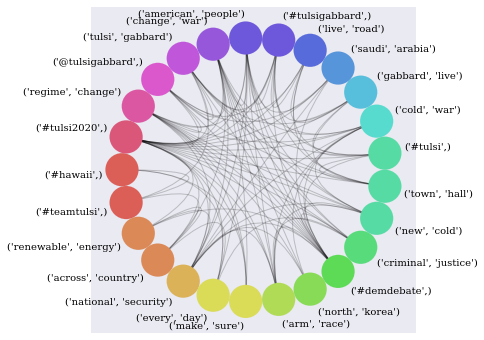

High Counts (10): [(('#tulsi2020',), {'count': 254}), (('regime', 'change'), {'count': 89}), (('@tulsigabbard',), {'count': 83}), (('tulsi', 'gabbard'), {'count': 72}), (('change', 'war'), {'count': 69}), (('#tulsigabbard',), {'count': 67}), (('american', 'people'), {'count': 67}), (('live', 'road'), {'count': 61}), (('saudi', 'arabia'), {'count': 48}), (('gabbard', 'live'), {'count': 44})]

Degree Centrality (5): [(('people', 'people'), 0.6785431512272367), (('#tulsi2020',), 0.4647664291369754), (('american', 'people'), 0.2897862232779097), (('regime', 'change'), 0.2723673792557403), (('end', 'war'), 0.2644497228820269)]

Betweenness Centrality (5): [(('people', 'people'), 0.21929977357203878), (('#tulsi2020',), 0.12323278834049677), (('regime', 'change'), 0.014743193394626897), (('american', 'people'), 0.01455265969423801), (('must', 'act'), 0.01299479118741245)]

PageRank (5): [(('people', 'people'), 0.024126080269190383), (('#tulsi2020',), 0.014507488723719146), (('regime', 'change

In [349]:
tweet_storage['@TulsiGabbard']['cleaned_tweets'], tweet_storage['@TulsiGabbard']['terms_w_counts'], tweet_storage['@TulsiGabbard']['G'] = graph_and_summarize_tweets('@TulsiGabbard', num_tweets=2000)